# Тихонов Василий: Python Advanced. Функции. Домашнее задание (HW) 

In [164]:
!pip install -q -U kaggle_environments

In [165]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from kaggle_environments import make, evaluate

#### Агент: всегда играющет "камень" - это значение 0

In [166]:
%%writefile rock_agent.py

def rock_agent(observation, configuration):
    return 0

Overwriting rock_agent.py


#### Агент: всегда играет "бумага" - это значение 1

In [167]:
%%writefile paper_agent.py

def paper_agent(observation, configuration):
    return 1

Overwriting paper_agent.py


#### Агент: всегда играет "ножницы" - это значение 2

In [168]:
%%writefile scissors_agent.py

def scissors_agent(observation, configuration):
    return 2

Overwriting scissors_agent.py


#### Агент: производит то же самое действие, что и оппонент на прошлом ходу

In [169]:
%%writefile copy_opponent.py

def copy_opponent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent.py


#### Агент: поражает последнее последнее действие соперника

In [170]:
%%writefile reactionary.py

import random
from kaggle_environments.envs.rps.utils import get_score

last_react_action = None

def reactionary(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Overwriting reactionary.py


#### Агент: контрреакция

In [171]:
%%writefile counter_reactionary.py

last_counter_action = None

def counter_reactionary(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Overwriting counter_reactionary.py


#### Агент: статистический

In [172]:
%%writefile statistical.py

action_histogram = {}

def statistical(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Overwriting statistical.py


#### Агент: [равновесие Д.Нэша](https://en.wikipedia.org/wiki/Nash_equilibrium)

In [173]:
%%writefile nash_equilibrium_agent.py

import random

def nash_equilibrium_agent(observation, configuration):
    return random.randint(0, 2)

Overwriting nash_equilibrium_agent.py


#### Первый бой

Воспользуемся функцией evaluate из библиотеки kaggle_environments с помощью которой запустим наших агентов и проведем эксперимент на заданном количестве игр

In [174]:
env = make(
    "rps", 
    configuration={
        "episodeSteps": 10
    }
)

In [175]:
env.run(
    ["rock_agent.py", "scissors_agent.py"]
)

env.render(mode="ipython", width=500, height=400)

#### Проведение турнира

In [176]:
list_names = [
    "rock_agent", 
    "paper_agent", 
    "scissors_agent",
    "copy_opponent",  
    "reactionary", 
    "counter_reactionary", 
    "statistical", 
    "nash_equilibrium_agent",
]
list_agents = [agent_name+".py" for agent_name in list_names]

scores = np.zeros((len(list_names), len(list_names)), dtype=int)

In [177]:
for ind_agent_1 in tqdm(range(len(list_names))):
  for ind_agent_2 in range(ind_agent_1 + 1, len(list_names)):
        
    current_score = evaluate(
      "rps", 
      [list_agents[ind_agent_1], list_agents[ind_agent_2]], 
      configuration={"episodeSteps": 1000}
    )
    scores[ind_agent_1, ind_agent_2] = current_score[0][0] if current_score[0][0] else -1
    scores[ind_agent_2, ind_agent_1] = current_score[0][1] if current_score[0][1] else -1

100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'rock_agent'),
  Text(0, 1.5, 'paper_agent'),
  Text(0, 2.5, 'scissors_agent'),
  Text(0, 3.5, 'copy_opponent'),
  Text(0, 4.5, 'reactionary'),
  Text(0, 5.5, 'counter_reactionary'),
  Text(0, 6.5, 'statistical'),
  Text(0, 7.5, 'nash_equilibrium_agent')])

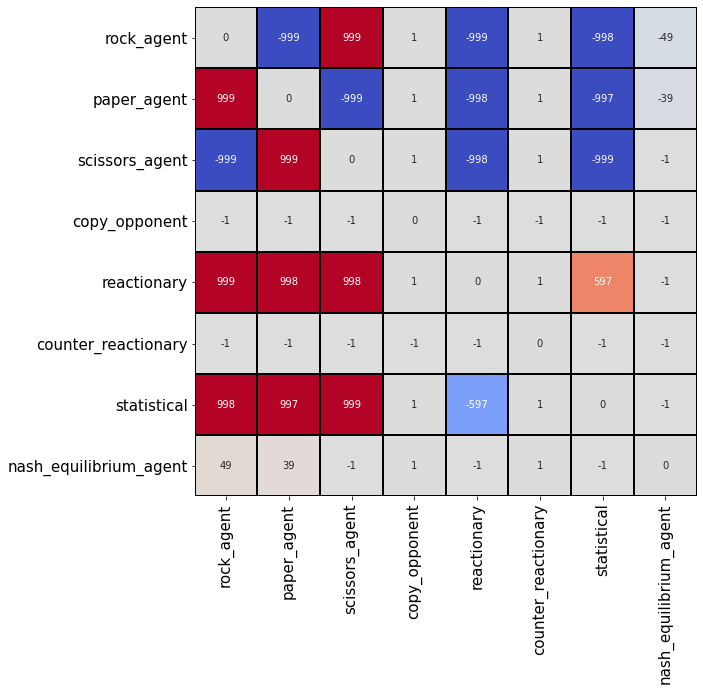

In [178]:
df_scores = pd.DataFrame(
    scores, 
    index=list_names, 
    columns=list_names,
)


plt.figure(figsize=(9, 9))
sns.heatmap(
    df_scores, annot=True, cbar=False, cmap='coolwarm', linewidths=1, linecolor='black', fmt="d"
)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)